# House Price Prediction

## Exploratory Data Analysis

First importing the data, relevant packages and conducting EDA, in preparation for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import neighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
house_train = pd.read_csv("train.csv")
house_train.head()

,Train_ID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,60,RL,88.0,12128,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,MnPrv,NaN,0,11,2006,WD,Abnorml,209000
1,2,120,RL,48.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,254000
2,3,50,RL,120.0,17360,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,172500
3,4,20,RL,73.0,8688,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,232000
4,5,80,RL,88.0,15312,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2009,COD,Normal,148000


In [4]:
house_test = pd.read_csv("test.csv")
house_test.head()

,Test_ID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,1,80,RL,120.0,19296,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,5,2009,WD,Normal
1,2,20,RL,80.0,10928,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
2,3,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
3,4,20,RL,60.0,8428,Pave,NaN,IR2,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal
4,5,50,RM,50.0,9140,Pave,NaN,Reg,HLS,AllPub,...,200,0,NaN,MnPrv,NaN,0,4,2010,COD,Normal


In [5]:
old_obs_n = house_train.shape[0]
print(f'Train dataset has {house_train.shape[0]} rows and {house_train.shape[1]} columns.')
print(f'Test dataset has {house_test.shape[0]} rows and {house_test.shape[1]} columns.')

Train dataset has 1570 rows and 81 columns.
Test dataset has 1210 rows and 80 columns.


The datasets are moderately large and have a large number of features.

In [6]:
print(f'There are {house_train.isnull().any().sum()} columns in train dataset with missing values.')

There are 24 columns in train dataset with missing values.


There are a number of columns with missing values. These need to be investigated before we engage in feature engineering.

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(house_train.dtypes)

Train_ID             int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
B

There are a number of qualitative variables that may require dummy variables to be created for these. This will be applied after an individual inspection of each of the variables in feature engineering.

Before identifying the most ideal features through a correlation heatmap feature engineering, we will first delve into each of the variables to ensure that the data having been inputted is logically consistent i.e. values correspond logically with the variable.

In [8]:
col_names = list(house_train.columns)

# for i in col_names:
#     plt.hist(house_train[i].dropna(), bins=50);
#     if i == "Year Remod/Add":
#         i = "Year Remod-Add"
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     else:
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     plt.show()

Nothing too unusual is noticeable in the data, however there is some skewness to a number of features and should be considered in feature engineering.

Now, using an IQR approach to identifying outliers these should be noted.

In [9]:
# to only consider numerical features in outlier detection
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = house_train.select_dtypes(include=numerics).copy()

In [10]:
del newdf['Train_ID']

In [11]:
Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1

In [12]:
house_train_out = newdf[((newdf < (Q1 - 1.5 * IQR)) |(newdf > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [13]:
print(f'The dataset has {house_train_out.shape[0]} outliers.')

The dataset has 966 outliers.


## Feature Engineering

First we will examine for the most relevant numerical variables in the dataset. Later, the most relevant categorical features will be converted to dummies so that they can be usable for predictive modelling.

Minusing the year it was sold in to the year it was constructed the new variable 'Age' was created. Also, minusing the last year it was remodelled or had additions made to the house to the year it was sold was added as the 'Last remod/add' feature. 

In [14]:
house_train['Age'] = house_train['Yr Sold'] - house_train['Year Built']
house_train['Last remod/add'] = house_train['Yr Sold'] - house_train['Year Remod/Add']

house_test['Age'] = house_test['Yr Sold'] - house_test['Year Built']
house_test['Last remod/add'] = house_test['Yr Sold'] - house_test['Year Remod/Add']

In [15]:
num_house_train = house_train[['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add','SalePrice']].copy()

Let's create a series of scatter plots of the narrowed numerical features against 'SalePrice' to understand what relationships may be present between these variables.

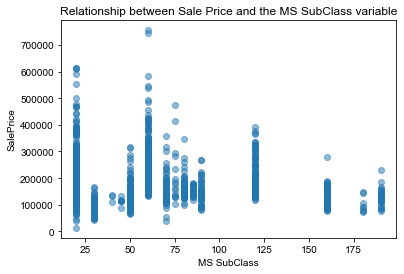

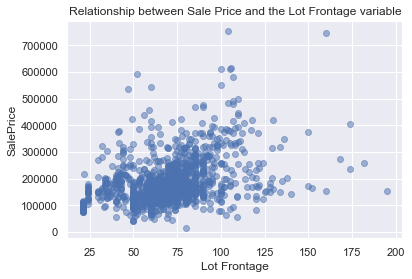

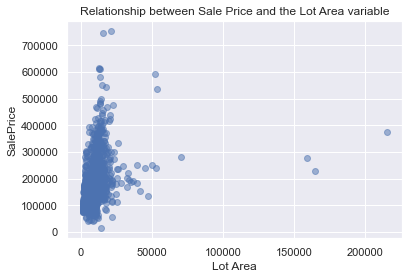

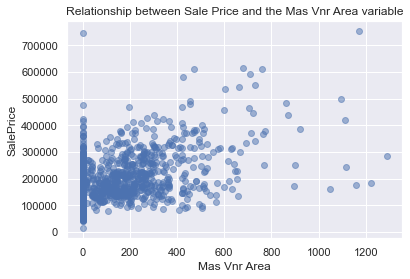

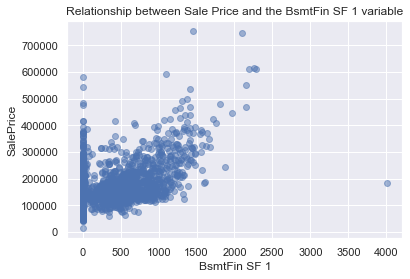

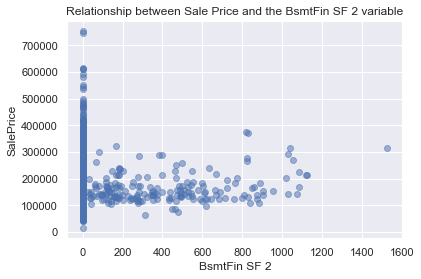

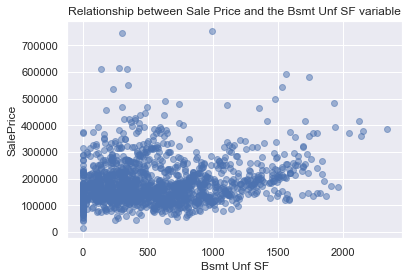

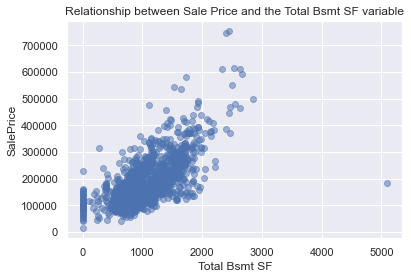

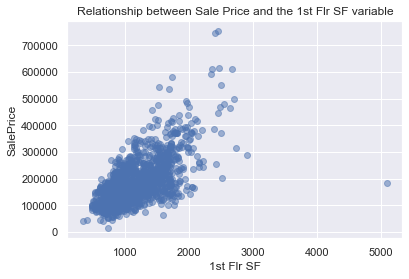

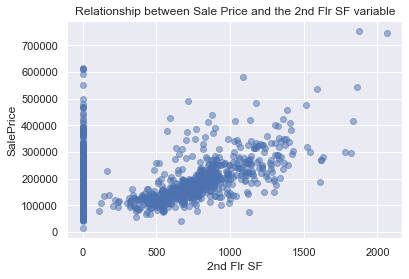

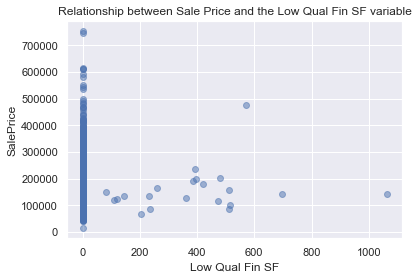

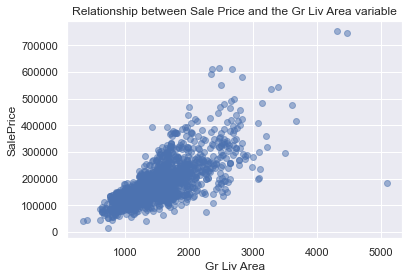

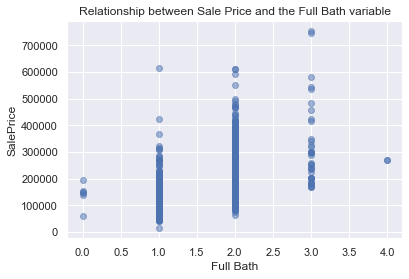

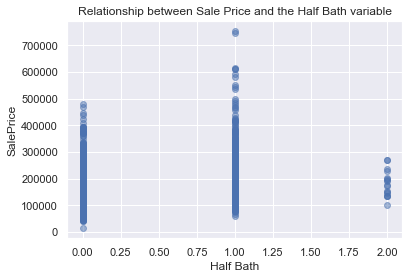

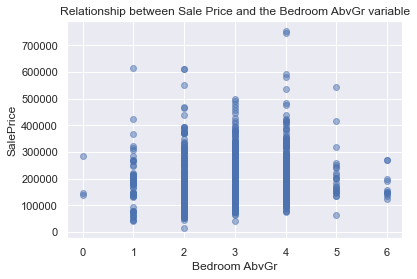

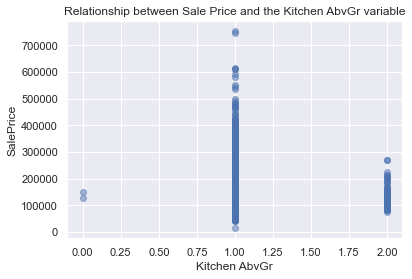

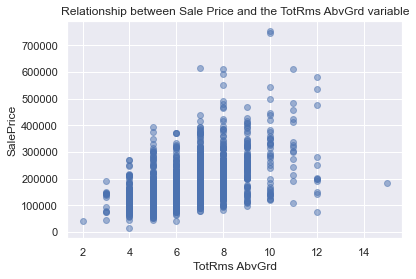

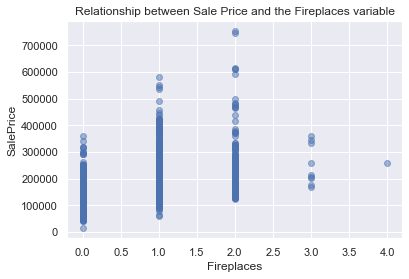

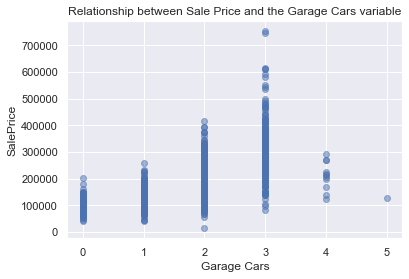

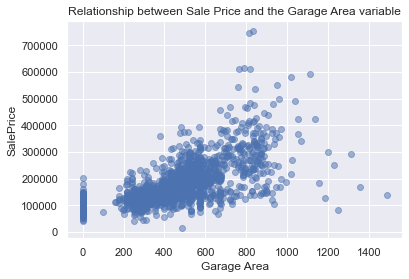

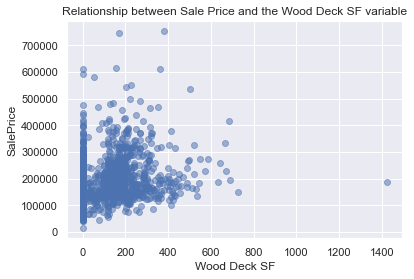

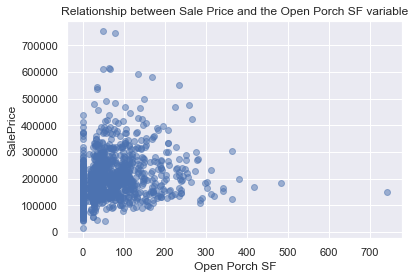

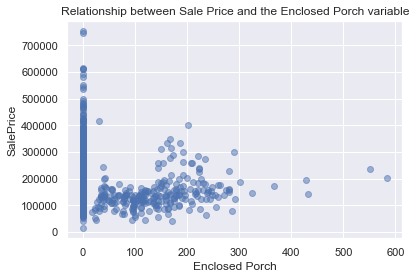

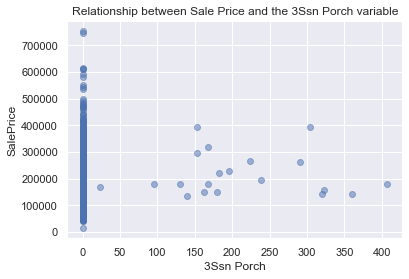

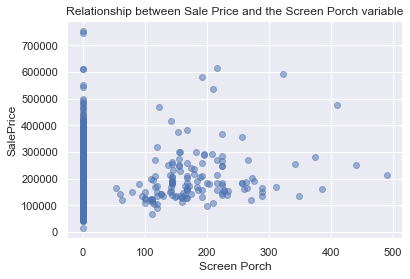

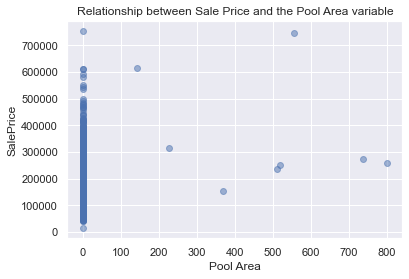

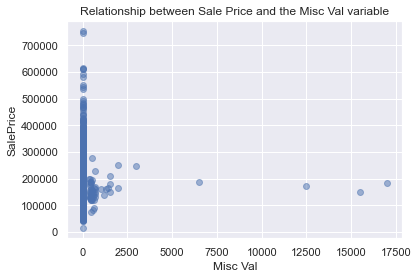

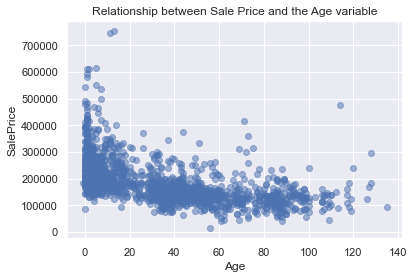

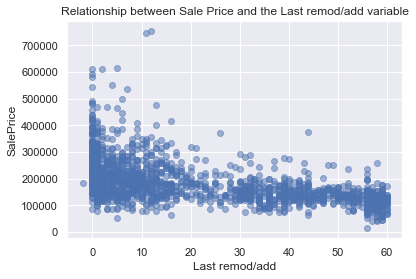

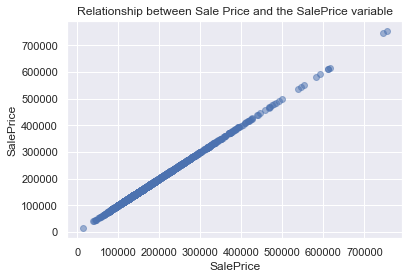

In [16]:
col_names = list(num_house_train.columns)

for i in col_names:
    plt.scatter(num_house_train[i], num_house_train['SalePrice'], alpha = 0.5);
    plt.title(f'Relationship between Sale Price and the {i} variable');
    sns.set(font_scale=1)
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    if i == "Last remod/add":
        plt.savefig(f'Relationship between Sale Price and the Last remod-add variable')
    else:
        plt.savefig(f'Relationship between Sale Price and the {i} variable')
    plt.show()

Since it was clear earlier that there was some heavy skewing of the data in some features, this has made the identifying of a relationship amongst these features more difficult. Therefore, for the purposes of making use of as many variables as possible the identified outliers from above will be removed and the scatter plots re-examined.

In [17]:
Q1 = num_house_train.quantile(0.25)
Q3 = num_house_train.quantile(0.75)
IQR = Q3 - Q1

In [18]:
num_house_train_out = num_house_train[~((num_house_train < (Q1 - 1.5 * IQR)) |(num_house_train > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [19]:
print(f'The dataset has {num_house_train_out.shape[0]} observations left.')

The dataset has 667 observations left.


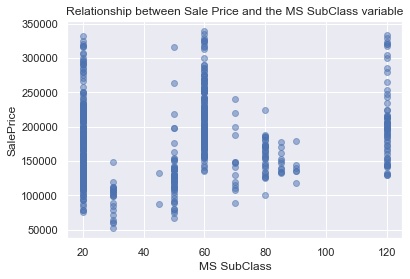

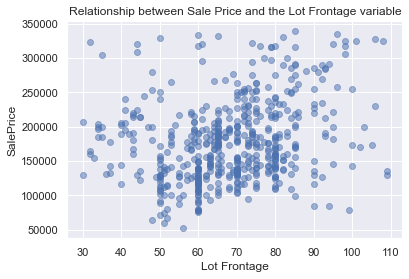

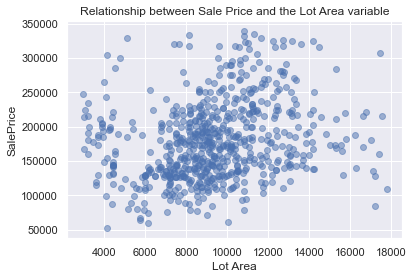

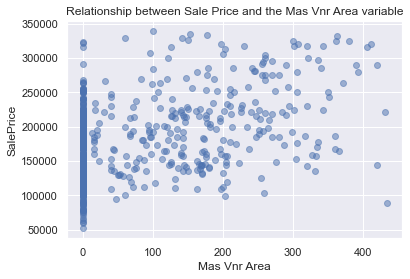

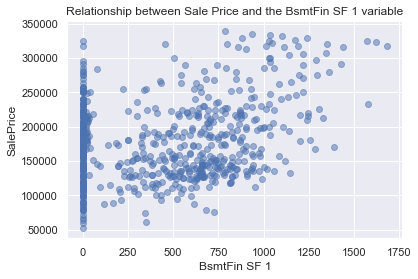

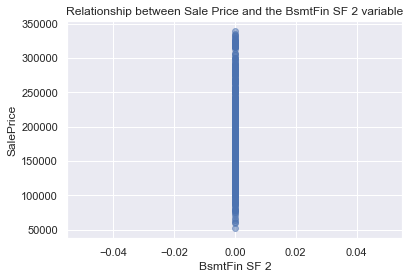

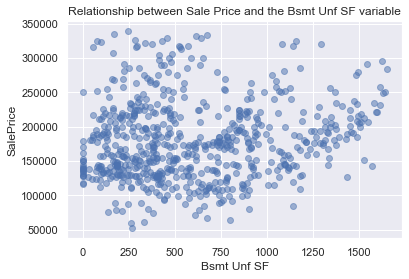

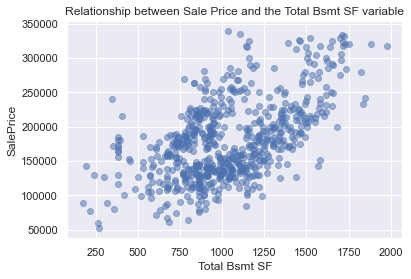

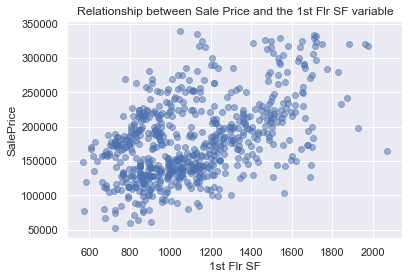

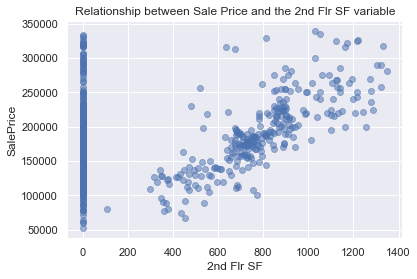

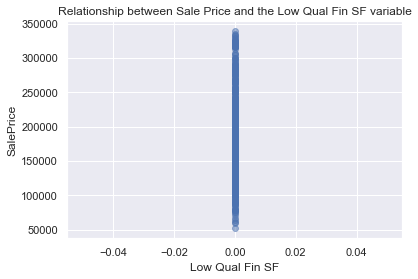

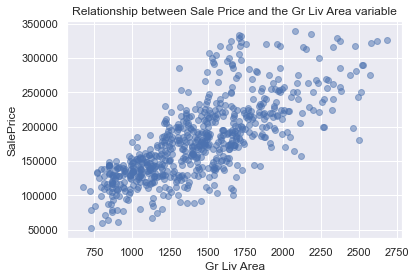

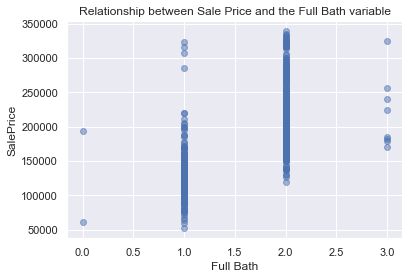

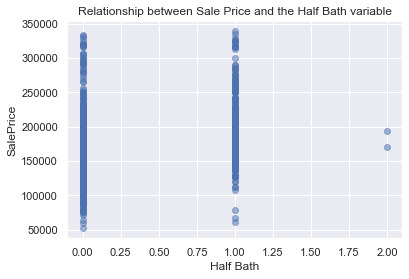

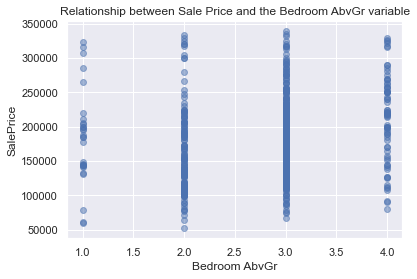

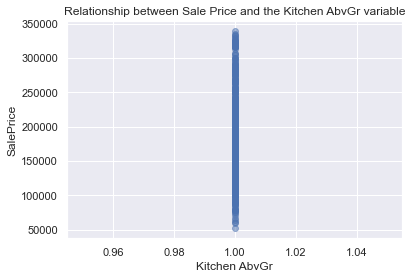

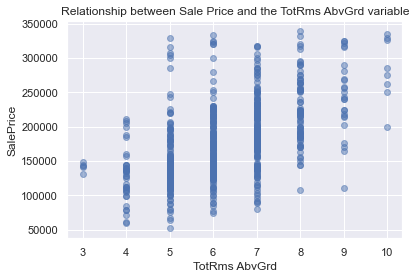

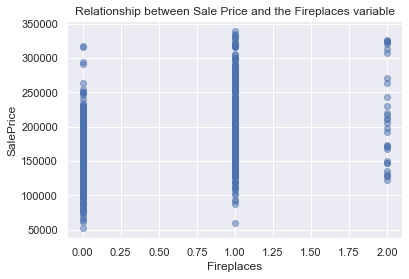

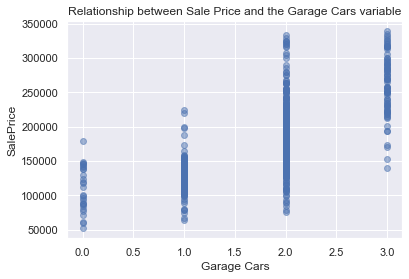

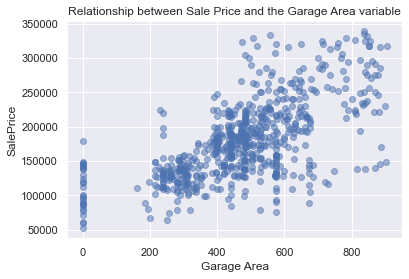

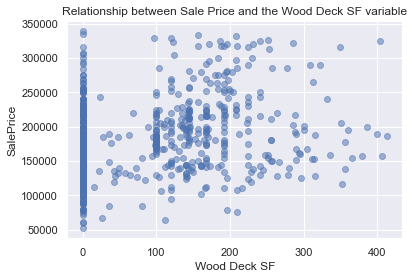

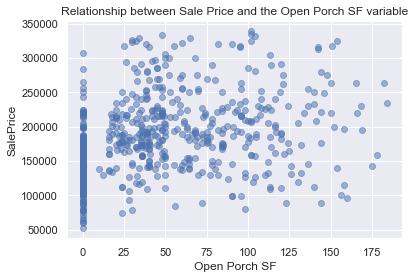

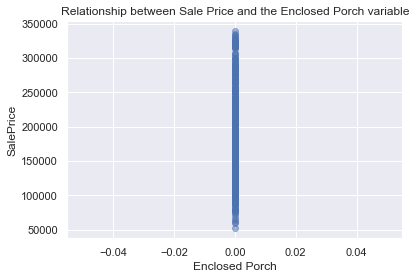

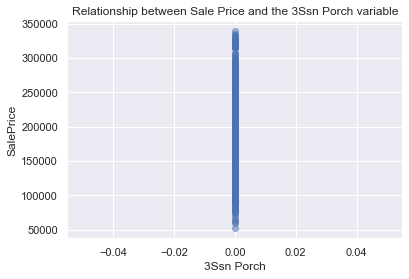

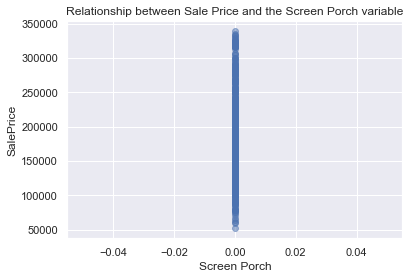

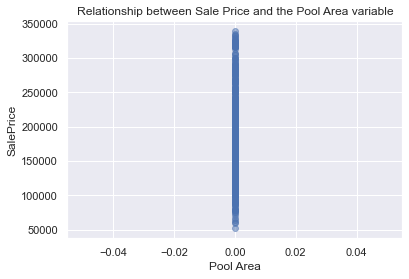

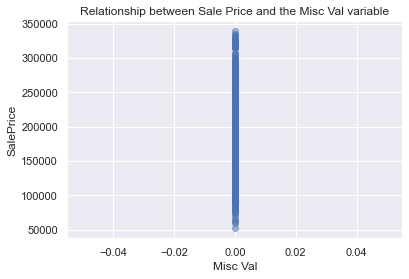

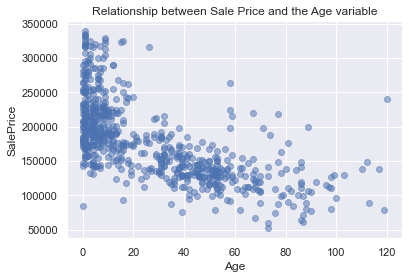

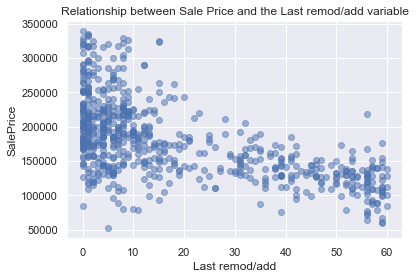

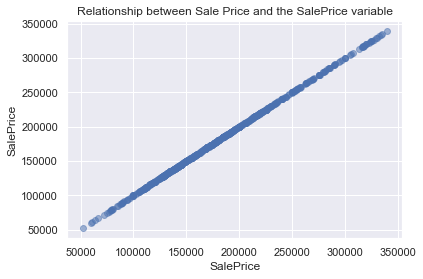

In [20]:
for i in col_names:
    plt.scatter(num_house_train_out[i], num_house_train_out['SalePrice'], alpha = 0.5);
    plt.title(f'Relationship between Sale Price and the {i} variable');
    sns.set(font_scale=1)
    plt.xlabel(i)
    plt.ylabel("SalePrice")
    if i == "Last remod/add":
        plt.savefig(f'Relationship between Sale Price and the Last remod-add variable')
    else:
        plt.savefig(f'Relationship between Sale Price and the {i} variable')
    plt.show()

Viewing the scatter plots above the best variables to consider are "Gr Liv Area", "Garage Area", "Age" and "Last remod/add". This is due to these showing some form of a non-linear relationship. "Total Bsmt SF" and "1st Flr SF" could also be included in model construction, however, their relationship is not as strong as the features mentioned. This should be accounted for when evaluating model performance.

In [21]:
# MAY OR MAY NOT NEED? ONLY IF THERE WERE FEATURES THAT WOULD HAVE CONTAINED NA VALUES THAT 
#WOULD HAVE BEEN HARD TO JUSTIFY AS A DUMMY CAUSE NO ADDITIONAL INFO ON THEM

# nan_values = num_house_train_out.isna()
# nan_columns = nan_values.any()

# columns_with_nan = num_house_train_out.columns[nan_columns].tolist()
# columns_with_nan

In [22]:
# MAY OR MAY NOT NEED? ONLY IF THERE WERE FEATURES THAT WOULD HAVE CONTAINED NA VALUES THAT 
#WOULD HAVE BEEN HARD TO JUSTIFY AS A DUMMY CAUSE NO ADDITIONAL INFO ON THEM

# nan_values = house_test.isna()
# nan_columns = nan_values.any()

# columns_with_nan = house_test.columns[nan_columns].tolist()
# columns_with_nan

To see if any relationship is present between the categorical variables and the Sales Price predictor, box plots will be made between these.

In [23]:
num_var = ['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add','SalePrice']

col_names = list(house_train.columns)

def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

cat_var = returnNotMatches(col_names, num_var)[0]
cat_var.remove('Train_ID')
cat_var.remove('Year Built')
cat_var.remove('Year Remod/Add')
cat_var.remove('Garage Yr Blt')

To ensure we were working with the same data with the outlier observations removed, the dataset of the numerical variables with its outliers removed was to be joined with the rest of its categorical features. Also, NA values in the join of categorical variables were replaced with the string "NONE(na rep)". This was to observe if there was any meaning behind particular features that had NA values recorded.

Also we compare the performance of a dataset with the outliers to see if any difference is possible.

In [24]:
mergedDf = num_house_train_out.merge(house_train[cat_var].fillna('NONE(na rep)'), left_index=True, right_index=True)

In [25]:
print(f'The dataset has {mergedDf.shape[0]} observations left.')

The dataset has 667 observations left.


Since the new joined dataframe gives the same number of observations that was found from the numerical variable dataset, we can confirm a successful join.

An error was run into when constructing the boxplots for the variable "Pool QC" and it was due to the whole column containing null values. Thus, the categorical variable was removed.

In [26]:
mergedDf["Pool QC"].unique()

array(['NONE(na rep)'], dtype=object)

In [27]:
cat_var.remove("Pool QC")

In [28]:
# for i in cat_var:
#     figure(num=None, figsize=(10, 8))
#     mergedDf[i] = mergedDf[i].astype(str)
#     x=dict(mergedDf.groupby([i])['SalePrice'].median())
#     sns.boxplot(x = mergedDf[i], y = mergedDf['SalePrice'], boxprops=dict(alpha=.3), order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}));
# #     boxplot_sorted(house_train_out, by = [i], column = 'SalePrice')
#     sns.stripplot(x=i, y="SalePrice", data=mergedDf, alpha=0.7, order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}))
#     plt.title(f'Relationship between Sale Price and the {i} variable');
#     plt.xticks(rotation=30)
#     sns.set(font_scale=1)
#     plt.xlabel(i)
#     plt.ylabel("SalePrice")
#     plt.savefig(f'Relationship between Sale Price and the {i} variable')
#     plt.show()

The best categorical features would be "Kitchen Qual" and "Garage Finish". This was on the basis that there was a sufficient number of observations between the different categories, a clear pattern was evident and that the variation (the whiskers of the boxplots) between groups did not overlap excessively. "Alley" would have also been considered, however, the presence of NA values that did not show a pattern or a distinct variation between the other categories meant NA values had little meaning.

Before confirming the final subset of features, to ensure that there were no issues in training and evaluation features that contained NA values were to be dropped. This was due to these being hard to infer any information since no descriptions of the data was provided. Thus, it was difficult to determine whether NA values had any meaning and would not be useful.

The same was done for the dataset with the outliers.

In [29]:
df_subset = mergedDf[["SalePrice", "Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Garage Finish"]].copy()

df_subset_test = house_test[["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']].copy()

In [30]:
print(f'There are {df_subset.isnull().any().sum()} columns in train dataset with missing values.')

There are 1 columns in train dataset with missing values.


In [31]:
nan_values = df_subset.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset.columns[nan_columns].tolist()
columns_with_nan

['Total Bsmt SF']

In [32]:
df_subset['Garage Finish'] = df_subset['Garage Finish'].fillna('NONE(na rep)')

In [33]:
null_data = df_subset[df_subset.isnull().any(axis=1)]
null_data

,SalePrice,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Garage Finish
508,79000,896,280,62,58,NaN,896,TA,Unf


In [34]:
df_subset['Total Bsmt SF'] = df_subset['Total Bsmt SF'].fillna(df_subset['Total Bsmt SF'].mean())

Since only one observation had a missing value for its "Total Bsmt SF" the NA value was replaced with the mean of the feature.

For a separate training set of outliers we did the same. Additional variables were also added since the plots containinng outliers had pattern relationships with "SalePrice".

In [35]:
df_subset_out = house_train[["SalePrice", "Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']].copy()

In [36]:
print(f'There are {df_subset_out.isnull().any().sum()} columns in train dataset with missing values.')

There are 3 columns in train dataset with missing values.


In [37]:
nan_values = df_subset_out.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset_out.columns[nan_columns].tolist()
columns_with_nan

['Total Bsmt SF', 'Garage Finish', 'BsmtFin SF 1']

In [38]:
df_subset_out['Garage Finish'] = df_subset_out['Garage Finish'].fillna('NONE(na rep)')

In [39]:
null_data = df_subset_out[df_subset_out.isnull().any(axis=1)]
null_data

,SalePrice,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Garage Finish,2nd Flr SF,BsmtFin SF 1,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars
508,79000,896,280,62,58,NaN,896,TA,Unf,0,NaN,1,4,0,1


Since only one observation had a missing value for its "Total Bsmt SF" and "BsmtFin SF 1" the NA values were replaced with the mean of their features.

In [40]:
df_subset_out['Total Bsmt SF'] = df_subset_out['Total Bsmt SF'].fillna(df_subset_out['Total Bsmt SF'].mean())
df_subset_out['BsmtFin SF 1'] = df_subset_out['BsmtFin SF 1'].fillna(df_subset_out['BsmtFin SF 1'].mean())

The same check was repeated for the test set to ensure that no evaluation errors occur.

In [41]:
nan_values = df_subset_test.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset_test.columns[nan_columns].tolist()
columns_with_nan

['Garage Area', 'Garage Finish', 'Garage Cars']

Since the test set contained NA values under the "Garage Area" the feature would ideally be dropped. However, the information under this variable is especially useful as seen in the relationship between this and "SalePrice" in the scatter plot. Hence, before finally removing the variable an examination of the NA values under this feature would allow for a more appropriate treatment of the dataframe.

"Garage Finish" was also found to contain NA values but the column was an exception as the categorical variable had meaningful na values; shown and explained in the boxplots above. Thus, these will be recoded to strings.

In [42]:
df_subset_test['Garage Finish'] = df_subset_test['Garage Finish'].fillna('NONE(na rep)')

In [43]:
null_data = df_subset_test[df_subset_test.isnull().any(axis=1)]
null_data

,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Garage Finish,2nd Flr SF,BsmtFin SF 1,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars
941,1828,NaN,84,8,859,942,Gd,NONE(na rep),886,548,2,6,0,NaN


Provided that only one observation had a NA value for "Garage Area" it was best replace the NA value with the mean of the feature rather than removing the entire "Garage Area" variable.

In [44]:
# df_subset_test = df_subset_test.drop([941])
df_subset_test['Garage Area'] = df_subset_test['Garage Area'].fillna(df_subset_test['Garage Area'].mean())
df_subset_test['Garage Cars'] = df_subset_test['Garage Cars'].fillna(df_subset_test['Garage Cars'].mean())

It was noticed that during model evaluation some of the observations in the test dataset under "Kitchen Qual" contained observations that had a category not defined in the training set.

In [45]:
df_subset["Kitchen Qual"].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [46]:
df_subset_test["Kitchen Qual"].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [47]:
df_subset_test[df_subset_test["Kitchen Qual"] == 'Po']

,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Garage Finish,2nd Flr SF,BsmtFin SF 1,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars
52,1224,180.0,93,60,689,725,Po,Unf,499,0,1,6,0,1.0


Similarly, since only one observation had the undefined category it was best to remove this observation from the test set.

In [48]:
### DON'T DO THIS UNTIL CONFIRMED POST ON ED...
# df_subset_test = df_subset_test.drop([52])

Therefore, the following features that were considered for model construction and evaluation were "Gr Liv Area","Total Bsmt SF", "Garage Area", "Age", "Last remod/add", "1st Flr SF" and "Garage Finish".

To finish feature engineering the train and test narrowed dataframes were finalised with its numerical variables being standardised. Typically the categorical variables would have been dummified here too, however, to simplify the model construction workflow this will be done just before the subset of features is being used to train the model.

In [49]:
# train-set transformations
num_predictors = ["Gr Liv Area", "Garage Area", 'Total Bsmt SF', "Age", "Last remod/add", "1st Flr SF"]

mu=df_subset[num_predictors].mean() # mean for each feature
sigma=df_subset[num_predictors].std() # std for each feature

df_subset[num_predictors]=(df_subset[num_predictors]-mu)/sigma

In [50]:
## FOR THE OUTLIER INCLUSIVE DATASET

# train-set transformations
num_predictors = ["Gr Liv Area", "Garage Area", 'Total Bsmt SF', "Age", "Last remod/add", "1st Flr SF", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

mu=df_subset_out[num_predictors].mean() # mean for each feature
sigma=df_subset_out[num_predictors].std() # std for each feature

df_subset_out[num_predictors]=(df_subset_out[num_predictors]-mu)/sigma

In [51]:
# test-set transformations

mu=df_subset_test[num_predictors].mean() # mean for each feature
sigma=df_subset_test[num_predictors].std()
df_subset_test[num_predictors]=(df_subset_out[num_predictors]-mu)/sigma

## Model Construction

### kNN Regression

Using subset selection amongst the narrowed variables the most optimal model was derived.

In [52]:
def knn_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
    
        neighbours=np.arange(1, 51)
        best_score = -np.inf
        
        for k in neighbours: 
            if len(predictors) == 1:
                knn = KNeighborsRegressor(n_neighbors= k) 
                scores = cross_val_score(knn, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
                cv_score = np.mean(scores)
                if cv_score >= best_score:
                    best_score = cv_score
                    best_knn = knn
            else:
                knn = KNeighborsRegressor(n_neighbors = k) 
                scores = cross_val_score(knn, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
                # taking the average of scores across 5 folds
                cv_score = np.mean(scores)
                # use the cv score for model selection
                if cv_score >= best_score:
                    best_score = cv_score
                    best_knn = knn

        knn = best_knn
        # train the selected model with the whole train set
        knn.fit(pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response])
        # Predict the test data with the selected and re-estimated model
        predictions = knn.predict(pd.get_dummies(test_dataset[predictors], drop_first=True))
        # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
        cv_rmse = np.sqrt(-best_score)
        print(f'For feature selection {predictors} best K is {knn.n_neighbors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        # print(f'Test RMSE: {test_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            # best_test = test_rmse
            best_features = predictors
            best_overall_knn = best_knn
            
#         if test_rmse < best_test_t:
#             best_features_score_t = cv_rmse
#             best_test_t = test_rmse
#             best_features_t = predictors
#             best_overall_knn_t = best_knn
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')
    
    return [best_features, best_overall_knn, best_features_score, predictions]

In [67]:
# getting the different combinations of features sets

all_features = ["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", 
                      "1st Flr SF", "Garage Finish"]

feature_combinations = []

for i in range(1,len(all_features)+1):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))

In [66]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

print('-------------WITHOUT OUTLIERS-------------')

best_set_model.append(knn_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_knn_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best kNN model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')
print(f'Number of neighbours: {overall_best_knn_cv.n_neighbors}')

-------------WITHOUT OUTLIERS-------------
For feature selection ['Gr Liv Area'] best K is 37
Cross Validation RMSE: 39387.710040859936
-------------------------------------------
For feature selection ['Garage Area'] best K is 17
Cross Validation RMSE: 41650.08738599
-------------------------------------------
For feature selection ['Age'] best K is 37
Cross Validation RMSE: 40912.56891677655
-------------------------------------------
For feature selection ['Last remod/add'] best K is 44
Cross Validation RMSE: 45614.698885302096
-------------------------------------------
For feature selection ['1st Flr SF'] best K is 45
Cross Validation RMSE: 49808.62779196149
-------------------------------------------
For feature selection ['Garage Finish'] best K is 19
Cross Validation RMSE: 45708.300122516
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area'] best K is 30
Cross Validation RMSE: 30919.502816653367
----------------------------------------

KeyboardInterrupt: 

In [55]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("Predictions_without_outliers.csv")

In [56]:
# reevaluate predictions to include the dropped observations and disregard the variables since they contain NA values...
predictions

,SalePrice
Test_ID,
0,129362.5
1,138487.5
2,129362.5
3,129362.5
4,129362.5
...,...
1205,129362.5
1206,138487.5
1207,134425.0


Since the predictions gave a low test score on the dataset without the outliers, models with the outliers and additional variables will be done next.

First the best model amongst the initial 7 features was determined. Then different combinations of the additional variables were made and added to the best set. This was to optimise computation time.

In [68]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

print('---------------WITH OUTLIERS---------------')

best_set_model.append(knn_multiple_test(feature_combinations, 'SalePrice', df_subset_out, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_knn_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best kNN model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')
print(f'Number of neighbours: {overall_best_knn_cv.n_neighbors}')

---------------WITH OUTLIERS---------------
For feature selection ['Gr Liv Area'] best K is 46
Cross Validation RMSE: 57165.874904966135
-------------------------------------------
For feature selection ['Garage Area'] best K is 37
Cross Validation RMSE: 60529.88957629054
-------------------------------------------
For feature selection ['Age'] best K is 46
Cross Validation RMSE: 65079.31034999502
-------------------------------------------
For feature selection ['Last remod/add'] best K is 49
Cross Validation RMSE: 68432.39853994014
-------------------------------------------
For feature selection ['1st Flr SF'] best K is 43
Cross Validation RMSE: 62350.2599745983
-------------------------------------------
For feature selection ['Garage Finish'] best K is 38
Cross Validation RMSE: 69786.00580877821
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area'] best K is 31
Cross Validation RMSE: 47546.83922591611
-------------------------------------

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Garage Finish'] best K is 46
Cross Validation RMSE: 49615.02444727503
-------------------------------------------
For feature selection ['Garage Area', 'Age', '1st Flr SF', 'Garage Finish'] best K is 9
Cross Validation RMSE: 42958.19056146231
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', '1st Flr SF', 'Garage Finish'] best K is 9
Cross Validation RMSE: 42713.32483780483
-------------------------------------------
For feature selection ['Age', 'Last remod/add', '1st Flr SF', 'Garage Finish'] best K is 10
Cross Validation RMSE: 45857.23977569475
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', '1st Flr SF'] best K is 9
Cross Validation RMSE: 34988.412363691175
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Garage Finish'] bes

In [69]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("Predictions_with_outliers.csv")

Variable additions are below.

In [149]:
# getting the different combinations of features sets

all_features = ['2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']

feature_combinations = []

for i in range(1,len(all_features)+1):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))
    
    
original_subset = ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF']    


for i in range(len(feature_combinations)):
    feature_combinations[i] = original_subset + feature_combinations[i]

In [150]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

print('---------------WITH OUTLIERS---------------')

best_set_model.append(knn_multiple_test(feature_combinations, 'SalePrice', df_subset_out, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_knn_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best kNN model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')
print(f'Number of neighbours: {overall_best_knn_cv.n_neighbors}')

---------------WITH OUTLIERS---------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '2nd Flr SF'] best K is 4
Cross Validation RMSE: 34129.17300407669
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'BsmtFin SF 1'] best K is 6
Cross Validation RMSE: 33850.94717887218
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath'] best K is 5
Cross Validation RMSE: 33630.32921048658
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd'] best K is 9
Cross Validation RMSE: 34498.575012169356
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Fireplaces'] best K is 12
Cross

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best K is 9
Cross Validation RMSE: 33112.144578327265
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best K is 6
Cross Validation RMSE: 35122.193770540536
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Full Bath', 'Fireplaces', 'Garage Cars'] best K is 7
Cross Validation RMSE: 32704.99640583421
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 9
Cross Validation RMSE: 33464.84412059966
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 

In [155]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("Predictions_with_outliers_added_vars.csv")

In [70]:
# reevaluate predictions to include the dropped observations and disregard the variables since they contain NA values...
predictions

,SalePrice
Test_ID,
0,106150.000000
1,113791.666667
2,106150.000000
3,111858.333333
4,106150.000000
...,...
1205,111858.333333
1206,113791.666667
1207,101541.666667


### Support Vector Regression

In [ ]:
def svr_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
    
        neighbours=np.arange(1, 51)
        best_score = -np.inf
        
        svr = SVR(kernel = 'sigmoid', degree = 10) 
        scores = cross_val_score(svr, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
        cv_score = np.mean(scores)
        
        best_svr = svr
        # train the selected model with the whole train set
        svr.fit(pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response])
        # Predict the test data with the selected and re-estimated model
        predictions = svr.predict(pd.get_dummies(test_dataset[predictors], drop_first=True))
        cv_rmse= np.sqrt(-cv_score)        
        
        print(f'For feature selection {predictors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            best_features = predictors
            best_overall_svr = best_svr
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')

    return [best_features, best_overall_svr, best_features_score, predictions]

In [138]:
# getting the different combinations of features sets

all_features = ['2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']

feature_combinations = []

for i in range(1,6):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))
    
    
original_subset = ["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Garage Finish"]    


for i in range(len(feature_combinations)):
    feature_combinations[i] = original_subset + feature_combinations[i]

[['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  '2nd Flr SF'],
 ['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  'BsmtFin SF 1'],
 ['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  'Full Bath'],
 ['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  'TotRms AbvGrd'],
 ['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  'Fireplaces'],
 ['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  'Garage Cars'],
 ['Gr Liv Area',
  'Garage Area',
  'Age',
  'Last remod/add',
  'Total Bsmt SF',
  '1st Flr SF',
  'Garage Finish',
  '2nd Flr SF',
  'BsmtFin SF 1'],
 ['Gr Liv Area',
  'Garage Area',
  'Ag

In [ ]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

print('-------------WITHOUT OUTLIERS-------------')

best_set_model.append(svr_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_svr_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best SVR model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

In [ ]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("Predictions_without_outliers.csv")

In [ ]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

print('---------------WITH OUTLIERS---------------')

best_set_model.append(svr_multiple_test(feature_combinations, 'SalePrice', df_subset_out, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_svr_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best SVR model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

In [ ]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("Predictions_with_outliers.csv")